<a href="https://colab.research.google.com/github/Mattia-Colbertaldo/PrimacyRL/blob/main/dopamine_prl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General information on the execution on the Notebook
- The notebook is designed to be executed with a GPU activated but will work without
- The notebook should ***never*** be run with _run all_, as the exectution time can be extremely high and the notebook might request session restarts!
***The notebook might require restarts and updates to some source code...Pay attention to the comments***

In [1]:
# @title Installation of packages and games (might be unused)

# Install some prerequired dependencies
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

!pip install atari-py
!pip install ale-py
!pip install dm_control

!wget https://mujoco.org/download/mujoco210-linux-x86_64.tar.gz
!mkdir /root/.mujoco/
!tar -xf mujoco210-linux-x86_64.tar.gz -C /root/.mujoco
import os
os.environ['LD_LIBRARY_PATH'] += ':/root/.mujoco/mujoco210/bin'

# Install Mujoco python bindings
!pip install gym
!pip install free-mujoco-py
#!git clone https://github.com/openai/mujoco-py
#%cd mujoco-py
#!pip install -r requirements.txt
#!pip install -r requirements.dev.txt
#!pip install -e . --no-cache
#%cd ..
#!pip install mujoco-py
#!pip install "cython<3"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
software-properties-common is already the newest version (0.99.22.7).
The following additional packages will be installed:
  libegl-dev libgl-dev libgles-dev libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev
  libglvnd-dev libglx-dev libopengl-dev libosmesa6
The following NEW packages will be installed:
  libegl-dev libgl-dev libgl1-mesa-dev libgl1-mesa-glx libgles-dev libgles1 libglew-dev
  libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev libglx-dev libopengl-dev libosmesa6
  libosmesa6-dev
0 upgraded, 15 newly installed, 0 to remove and 19 not upgraded.
Need to get 3,952 kB of archives.
After this operation, 18.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglx-dev amd64 1.4.0-1 [14.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgl-dev amd64 1.4.0-1 [101 kB]
Get:3 http://archive.ubuntu.com/ubuntu 

***Restart the environment after this step!!!***

In [1]:
import os
os.environ['LD_LIBRARY_PATH'] += ':/root/.mujoco/mujoco210/bin'

In [1]:
# @title Test of the Mujoco env. "Don't execute usually"
import os
os.environ['LD_LIBRARY_PATH'] += ':/root/.mujoco/mujoco210/bin'
import mujoco_py
mj_path = mujoco_py.utils.discover_mujoco()
xml_path = os.path.join(mj_path, 'model', 'humanoid.xml')
model = mujoco_py.load_model_from_path(xml_path)
sim = mujoco_py.MjSim(model)

print(sim.data.qpos)
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sim.step()
print(sim.data.qpos)

Compiling /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx because it changed.
[1/1] Cythonizing /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx


INFO:root:running build_ext
INFO:root:building 'mujoco_py.cymj' extension
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr/local
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr/local/lib
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-31

In [2]:
# @title Install Dopamine from source
!git clone https://github.com/google/dopamine
!pip install -r dopamine/requirements.txt

# Install the dopamine package itself (required as there might be previous unseen instalations)
%cd dopamine
!pip install .
%cd ..

Cloning into 'dopamine'...
remote: Enumerating objects: 3989, done.
remote: Counting objects: 100% (1467/1467), done.
remote: Compressing objects: 100% (317/317), done.
remote: Total 3989 (delta 1168), reused 1150 (delta 1150), pack-reused 2522
Receiving objects: 100% (3989/3989), 21.12 MiB | 19.04 MiB/s, done.
Resolving deltas: 100% (2663/2663), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 624.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 858.3/858.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 25.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-an

In [2]:
# @title Import dependencies and set up base path
import numpy as np
import os
#import gin
#gin.enter_interactive_mode()
from dopamine.discrete_domains import run_experiment
from dopamine.colab import utils as colab_utils
from absl import flags
import gin.tf

BASE_PATH = '/tmp/colab_dopamine_run'  # @param

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes
/usr/local/lib/python3.10/dist-packages/gin/tf/__init__.py:48: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
/usr/local/lib/python3.10/dist-packages/flax/linen/module.py:77: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr, jax.dtypes.prng_key) for runtime detection of typed prng keys.
  KeyArray = Union[jax.Array, jax.random.KeyArray]  # pylint: disable=invalid-name
/usr/local/lib/python3.10/dist-packages/flax/linen/recurrent.py:45: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr, jax.dtypes.prng_key) for runtime detect

# Cartpole with two Agents

In [ ]:
DQN_PATH = os.path.join(BASE_PATH, 'cartpole/dqn')
# Modified from dopamine/agents/dqn/config/dqn_cartpole.gin
dqn_config = """
# Hyperparameters for a simple DQN-style Cartpole agent. The hyperparameters
# chosen achieve reasonable performance.
import dopamine.discrete_domains.gym_lib
import dopamine.discrete_domains.run_experiment
import dopamine.agents.dqn.dqn_agent
import dopamine.replay_memory.circular_replay_buffer
import gin.tf.external_configurables

DQNAgent.observation_shape = %gym_lib.CARTPOLE_OBSERVATION_SHAPE
DQNAgent.observation_dtype = %gym_lib.CARTPOLE_OBSERVATION_DTYPE
DQNAgent.stack_size = %gym_lib.CARTPOLE_STACK_SIZE
DQNAgent.network = @gym_lib.CartpoleDQNNetwork
DQNAgent.gamma = 0.99
DQNAgent.update_horizon = 1
DQNAgent.min_replay_history = 500
DQNAgent.update_period = 4
DQNAgent.target_update_period = 100
DQNAgent.epsilon_fn = @dqn_agent.identity_epsilon
DQNAgent.tf_device = '/gpu:0'  # use '/cpu:*' for non-GPU version
DQNAgent.optimizer = @tf.train.AdamOptimizer()

tf.train.AdamOptimizer.learning_rate = 0.001
tf.train.AdamOptimizer.epsilon = 0.0003125

create_gym_environment.environment_name = 'CartPole'
create_gym_environment.version = 'v1'
create_agent.agent_name = 'dqn'
TrainRunner.create_environment_fn = @gym_lib.create_gym_environment
Runner.num_iterations = 50
Runner.training_steps = 1000
Runner.evaluation_steps = 1000
Runner.max_steps_per_episode = 1000  # Default max episode length.

WrappedReplayBuffer.replay_capacity = 50000
WrappedReplayBuffer.batch_size = 128
"""
gin.parse_config(dqn_config, skip_unknown=False)

([],
 ['dopamine.discrete_domains.gym_lib',
  'dopamine.discrete_domains.run_experiment',
  'dopamine.agents.dqn.dqn_agent',
  'dopamine.replay_memory.circular_replay_buffer',
  'gin.tf.external_configurables'])

In [ ]:
# @title Train DQN on Cartpole
dqn_runner = run_experiment.create_runner(DQN_PATH, schedule='continuous_train')
print('Will train DQN agent, please be patient, may be a while...')
dqn_runner.run_experiment()
print('Done training!')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
Instructions for updating:
non-resource variables are not supported in the long term


Will train DQN agent, please be patient, may be a while...


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Done training!


In [ ]:
# @title Load the configuration for C51.

C51_PATH = os.path.join(BASE_PATH, 'cartpole/c51')
# Modified from dopamine/agents/rainbow/config/c51_cartpole.gin
c51_config = """
# Hyperparameters for a simple C51-style Cartpole agent. The hyperparameters
# chosen achieve reasonable performance.
import dopamine.agents.dqn.dqn_agent
import dopamine.agents.rainbow.rainbow_agent
import dopamine.discrete_domains.gym_lib
import dopamine.discrete_domains.run_experiment
import dopamine.replay_memory.prioritized_replay_buffer
import gin.tf.external_configurables

RainbowAgent.observation_shape = %gym_lib.CARTPOLE_OBSERVATION_SHAPE
RainbowAgent.observation_dtype = %gym_lib.CARTPOLE_OBSERVATION_DTYPE
RainbowAgent.stack_size = %gym_lib.CARTPOLE_STACK_SIZE
RainbowAgent.network = @gym_lib.CartpoleRainbowNetwork
RainbowAgent.num_atoms = 51
RainbowAgent.vmax = 10.
RainbowAgent.gamma = 0.99
RainbowAgent.update_horizon = 1
RainbowAgent.min_replay_history = 500
RainbowAgent.update_period = 4
RainbowAgent.target_update_period = 100
RainbowAgent.epsilon_fn = @dqn_agent.identity_epsilon
RainbowAgent.replay_scheme = 'uniform'
RainbowAgent.tf_device = '/gpu:*'  # use '/cpu:*' for non-GPU version
RainbowAgent.optimizer = @tf.train.AdamOptimizer()

tf.train.AdamOptimizer.learning_rate = 0.001
tf.train.AdamOptimizer.epsilon = 0.0003125

create_gym_environment.environment_name = 'CartPole'
create_gym_environment.version = 'v0'
create_agent.agent_name = 'rainbow'
TrainRunner.create_environment_fn = @gym_lib.create_gym_environment
Runner.num_iterations = 50
Runner.training_steps = 1000
Runner.evaluation_steps = 1000
Runner.max_steps_per_episode = 1000  # Default max episode length.

WrappedPrioritizedReplayBuffer.replay_capacity = 50000
WrappedPrioritizedReplayBuffer.batch_size = 128
"""
gin.parse_config(c51_config, skip_unknown=False)

([],
 ['dopamine.agents.dqn.dqn_agent',
  'dopamine.agents.rainbow.rainbow_agent',
  'dopamine.discrete_domains.gym_lib',
  'dopamine.discrete_domains.run_experiment',
  'dopamine.replay_memory.prioritized_replay_buffer',
  'gin.tf.external_configurables'])

In [ ]:
# @title Train C51 on Cartpole
c51_runner = run_experiment.create_runner(C51_PATH, schedule='continuous_train')
print('Will train agent, please be patient, may be a while...')
c51_runner.run_experiment()
print('Done training!')


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


Will train agent, please be patient, may be a while...
Done training!


In [ ]:
# @title Load the training logs.
#data = colab_utils.read_experiment(DQN_PATH, verbose=True,
#                                   summary_keys=['train_episode_returns'])
#data['agent'] = 'DQN'
#data['run'] = 1

import collections
parameter_set = collections.OrderedDict([
    ('agent', ['DQN', 'C51']),
    ('game', ['Cartpole'])
])

data = colab_utils.read_experiment(DQN_PATH, verbose=True,
                                      parameter_set=parameter_set,
                              summary_keys=['train_episode_returns'])

datac51 = colab_utils.read_experiment(C51_PATH, verbose=True,
                                      parameter_set=parameter_set,
                              summary_keys=['train_episode_returns'])

datac51['agent'] = 'C51'
datac51['run'] = 1
data['agent'] = 'DQN'
data['run'] = 1

data = data.merge(datac51, how='outer')

Reading statistics from: /tmp/colab_dopamine_run/cartpole/dqn//logs/log_49
Reading statistics from: /tmp/colab_dopamine_run/cartpole/dqn//logs/log_49
Reading statistics from: /tmp/colab_dopamine_run/cartpole/c51//logs/log_49
Reading statistics from: /tmp/colab_dopamine_run/cartpole/c51//logs/log_49


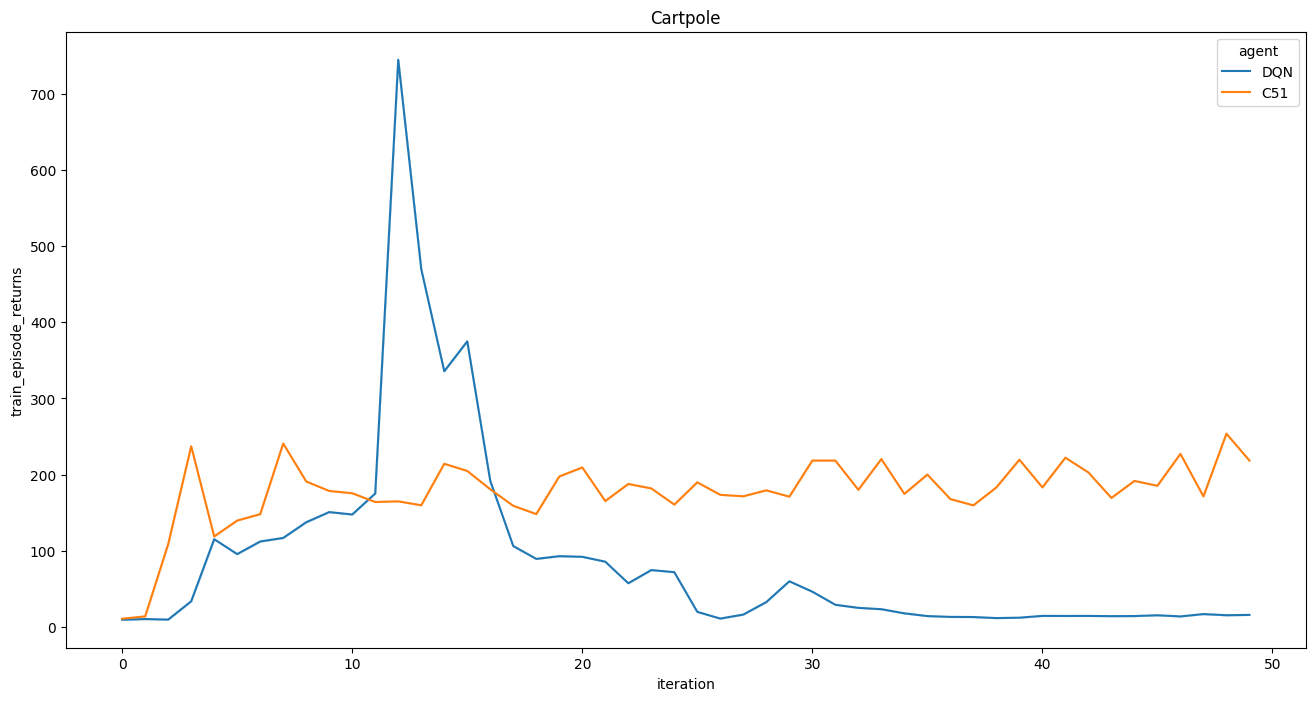

In [ ]:

#import seaborn as sns
#import matplotlib.pyplot as plt
#
#fig, ax = plt.subplots(figsize=(16,8))
#sns.lineplot(x='iteration', y='train_episode_returns', hue='agent',
#             data=data, ax=ax)
#plt.title('Cartpole')
#plt.show()

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x='iteration', y='train_episode_returns', hue='agent',
              data=data, ax=ax)
plt.title('Cartpole')
plt.show()

In [ ]:
# @title Test with some integrated Libs
#from dopamine.utils.line_plotter import LinePlotter

In [ ]:
#def getData():
 # return np.asarray(data['train_episode_returns'])

#parameter_set = collections.OrderedDict([
#    ('get_line_data_fn', getData),
 #   ('agent', ['DQN', 'C51']),
 #   ('game', ['Cartpole'])
#])
#lp = LinePlotter(parameter_set)
#lp.draw()

# Acrobot

In [ ]:
# @title Load the configuration for DQN.

DQN_PATH = os.path.join(BASE_PATH, 'dqn')
# Modified from dopamine/agents/dqn/config/dqn_acrobot.gin
dqn_config = """
# Hyperparameters for a simple DQN-style Acrobot agent. The hyperparameters
# chosen achieve reasonable performance.
import dopamine.agents.dqn.dqn_agent
import dopamine.agents.rainbow.rainbow_agent
import dopamine.discrete_domains.gym_lib
import dopamine.discrete_domains.run_experiment
import dopamine.replay_memory.prioritized_replay_buffer
import gin.tf.external_configurables

RainbowAgent.observation_shape = %gym_lib.ACROBOT_OBSERVATION_SHAPE
RainbowAgent.observation_dtype = %gym_lib.ACROBOT_OBSERVATION_DTYPE
RainbowAgent.stack_size = %gym_lib.ACROBOT_STACK_SIZE
RainbowAgent.network = @gym_lib.AcrobotRainbowNetwork
RainbowAgent.num_atoms = 51
RainbowAgent.vmax = 10.
RainbowAgent.gamma = 0.99
RainbowAgent.update_horizon = 1
RainbowAgent.min_replay_history = 500
RainbowAgent.update_period = 4
RainbowAgent.target_update_period = 100
RainbowAgent.epsilon_fn = @dqn_agent.identity_epsilon
RainbowAgent.replay_scheme = 'uniform'
RainbowAgent.tf_device = '/gpu:*'  # use '/cpu:*' for non-GPU version
RainbowAgent.optimizer = @tf.train.AdamOptimizer()

tf.train.AdamOptimizer.learning_rate = 0.1
tf.train.AdamOptimizer.epsilon = 0.0003125

create_gym_environment.environment_name = 'Acrobot'
create_gym_environment.version = 'v1'
create_agent.agent_name = 'rainbow'
Runner.create_environment_fn = @gym_lib.create_gym_environment
Runner.num_iterations = 50
Runner.training_steps = 1000
Runner.evaluation_steps = 1000
Runner.max_steps_per_episode = 1000

WrappedPrioritizedReplayBuffer.replay_capacity = 50000
WrappedPrioritizedReplayBuffer.batch_size = 128
"""
gin.parse_config(dqn_config, skip_unknown=False)

([],
 ['dopamine.agents.dqn.dqn_agent',
  'dopamine.agents.rainbow.rainbow_agent',
  'dopamine.discrete_domains.gym_lib',
  'dopamine.discrete_domains.run_experiment',
  'dopamine.replay_memory.prioritized_replay_buffer',
  'gin.tf.external_configurables'])

In [ ]:
dqn_runner = run_experiment.create_runner(DQN_PATH, schedule='continuous_train')
print('Will train DQN agent, please be patient, may be a while...')
dqn_runner.run_experiment()
print('Done training!')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Will train DQN agent, please be patient, may be a while...
Done training!


In [ ]:
import collections
parameter_set = collections.OrderedDict([
    ('agent', ['DQN']),
    ('game', ['Acrobot'])
])

data = colab_utils.read_experiment(DQN_PATH, verbose=True,
                                      parameter_set=parameter_set,
                              summary_keys=['train_episode_returns'])




data['agent'] = 'DQN'
data['run'] = 1


Reading statistics from: /tmp/colab_dopamine_run/dqn//logs/log_49


In [ ]:

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x='iteration', y='train_episode_returns', hue='agent',
              data=data, ax=ax)
plt.title('Acrobot')
plt.show()

# Play a different game

In [ ]:
from dopamine.agents.dqn import dqn_agent

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

GAME = 'Asterix'
LOG_PATH = os.path.join(BASE_PATH, 'dqn', GAME)

def create_dqn_agent(sess, environment, summary_writer=None):
  """The Runner class will expect a function of this type to create an agent."""
  return dqn_agent.DQNAgent(sess, num_actions=environment.action_space.n)

game_dqn_config = """
import dopamine.discrete_domains.atari_lib
import dopamine.discrete_domains.run_experiment
atari_lib.create_atari_environment.game_name = '{}'
atari_lib.create_atari_environment.sticky_actions = True
run_experiment.Runner.num_iterations = 200
run_experiment.Runner.training_steps = 10
run_experiment.Runner.max_steps_per_episode = 100
""".format(GAME)
gin.parse_config(game_dqn_config, skip_unknown=False)

In [ ]:
dqn_runner = run_experiment.TrainRunner(LOG_PATH, create_dqn_agent)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
print('Will train agent, please be patient, may be a while...')
dqn_runner.run_experiment()
print('Done training!')

Will train agent, please be patient, may be a while...
Done training!


In [ ]:
# @title Load the training logs.
dqn_data = colab_utils.read_experiment(
    LOG_PATH, verbose=True, summary_keys=['train_episode_returns'])
dqn_data['agent'] = 'MyRandomDQN'
dqn_data['run_number'] = 1

Reading statistics from: /tmp/colab_dopamine_run/dqn/Asterix//logs/log_49


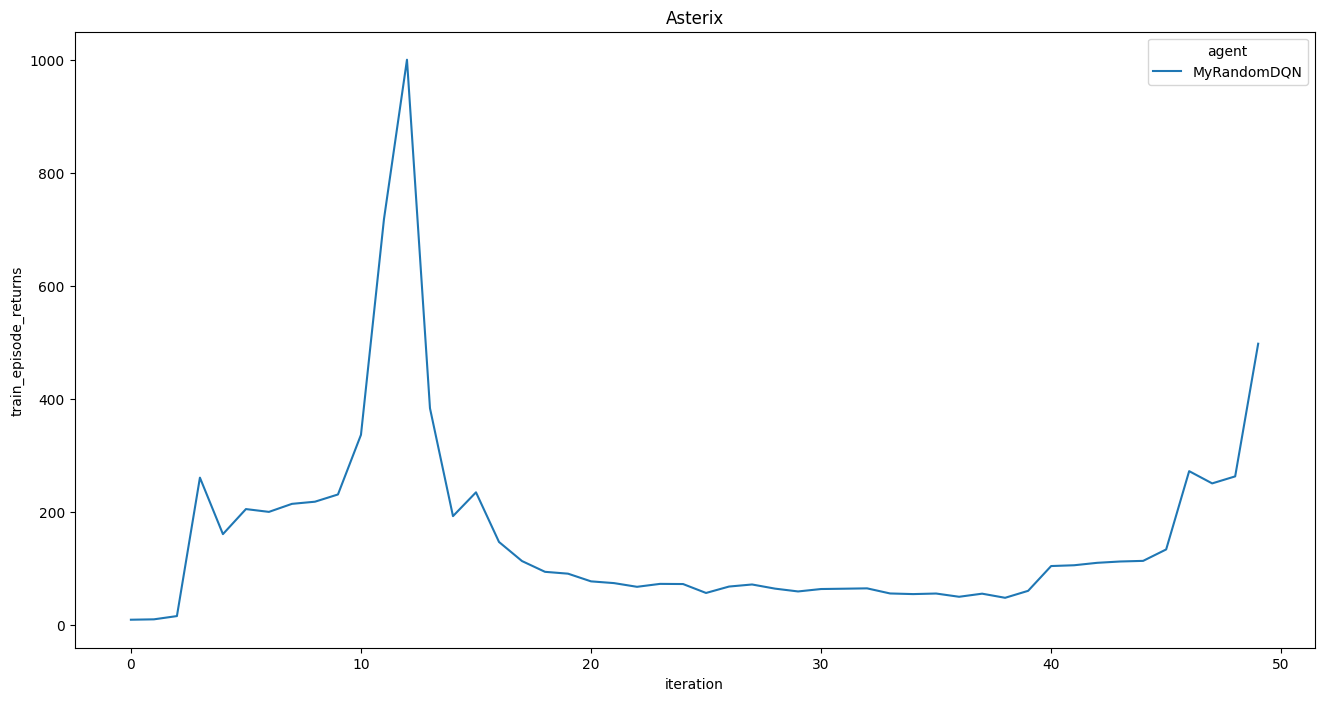

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(
    x='iteration', y='train_episode_returns', hue='agent',
    data=dqn_data, ax=ax)
plt.title(GAME)
plt.grid()
plt.show()

# Mujoco Environment Test

In [3]:
from dopamine.jax.agents.sac import sac_agent
from dopamine.continuous_domains import run_experiment
from dopamine.discrete_domains import gym_lib

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [4]:
GAME = 'HalfCheetah'
LOG_PATH = os.path.join(BASE_PATH, 'sac', GAME)


game_sac_config = """
SACAgent.reward_scale_factor = 0.1
SACAgent.network = @continuous_networks.SACNetwork
SACAgent.num_layers = 2
SACAgent.hidden_units = 256
SACAgent.gamma = 0.99
SACAgent.update_horizon = 1
SACAgent.min_replay_history = 10000  # agent steps
SACAgent.update_period = 1
SACAgent.target_update_type = 'soft'
SACAgent.target_smoothing_coefficient = 0.005
SACAgent.target_entropy = None  # Defaults to -num_action_dims/2
SACAgent.optimizer = 'adam'
SACAgent.seed = None  # Seed with the current time
SACAgent.observation_dtype = %sac_agent.STATE_DTYPE
create_optimizer.learning_rate = 3.0e-4
create_optimizer.beta1 = 0.9
create_optimizer.beta2 = 0.999
create_optimizer.eps = 1.0e-8

create_gym_environment.environment_name = '{}'
create_gym_environment.version = 'v2'
create_continuous_runner.schedule = 'continuous_train_and_eval'
create_continuous_agent.agent_name = 'sac'
ContinuousTrainRunner.create_environment_fn = @gym_lib.create_gym_environment
ContinuousRunner.num_iterations = 50
ContinuousRunner.training_steps = 1000
ContinuousRunner.evaluation_steps = 10000  # agent steps
ContinuousRunner.max_steps_per_episode = 1000
ContinuousRunner.clip_rewards = False

circular_replay_buffer.OutOfGraphReplayBuffer.replay_capacity = 1000000
circular_replay_buffer.OutOfGraphReplayBuffer.batch_size = 256
""".format(GAME)
gin.parse_config(game_sac_config)

([], [])

In [5]:
from absl import app
from absl import flags
from absl import logging
logging.set_verbosity('debug')

sac_runner = run_experiment.create_continuous_runner(LOG_PATH)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment HalfCheetah-v2 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
/usr/local/lib/python3.10/dist-packages/gym/envs/mujoco/mujoco_env.py:237: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will b

In [6]:
sac_runner.run_experiment()

INFO:absl:Beginning training...
INFO:absl:Starting iteration 10


INFO:absl:Average undiscounted return per training episode: -199.35
INFO:absl:Average training steps per second: 30.06


INFO:absl:Average undiscounted return per evaluation episode: -0.42
INFO:absl:[Iteration 10]: Train/NumEpisodes = 1
[Iteration 10]: Train/AverageReturns = -199.34776921351443
[Iteration 10]: Train/AverageStepsPerSecond = 30.061953309802277
[Iteration 10]: Eval/NumEpisodes = 10
[Iteration 10]: Eval/AverageReturns = -0.41710595466269257

INFO:absl:Starting iteration 11


INFO:absl:Average undiscounted return per training episode: -280.59
INFO:absl:Average training steps per second: 31.72


INFO:absl:Average undiscounted return per evaluation episode: -0.34
INFO:absl:[Iteration 11]: Train/NumEpisodes = 1
[Iteration 11]: Train/AverageReturns = -280.5905879406544
[Iteration 11]: Train/AverageStepsPerSecond = 31.720011942316354
[Iteration 11]: Eval/NumEpisodes = 10
[Iteration 11]: Eval/AverageReturns = -0.3357537310985996

INFO:absl:Starting iteration 12


INFO:absl:Average undiscounted return per training episode: -266.25
INFO:absl:Average training steps per second: 35.25


INFO:absl:Average undiscounted return per evaluation episode: -0.56
INFO:absl:[Iteration 12]: Train/NumEpisodes = 1
[Iteration 12]: Train/AverageReturns = -266.2492680733138
[Iteration 12]: Train/AverageStepsPerSecond = 35.250624066895824
[Iteration 12]: Eval/NumEpisodes = 10
[Iteration 12]: Eval/AverageReturns = -0.5613168610531807

INFO:absl:Starting iteration 13


INFO:absl:Average undiscounted return per training episode: -205.86
INFO:absl:Average training steps per second: 34.44


INFO:absl:Average undiscounted return per evaluation episode: -0.62
INFO:absl:[Iteration 13]: Train/NumEpisodes = 1
[Iteration 13]: Train/AverageReturns = -205.85716445840413
[Iteration 13]: Train/AverageStepsPerSecond = 34.44235819867271
[Iteration 13]: Eval/NumEpisodes = 10
[Iteration 13]: Eval/AverageReturns = -0.6223372399776577

INFO:absl:Starting iteration 14


INFO:absl:Average undiscounted return per training episode: -288.42
INFO:absl:Average training steps per second: 34.79


INFO:absl:Average undiscounted return per evaluation episode: -1.43
INFO:absl:[Iteration 14]: Train/NumEpisodes = 1
[Iteration 14]: Train/AverageReturns = -288.4182863721082
[Iteration 14]: Train/AverageStepsPerSecond = 34.79372780090444
[Iteration 14]: Eval/NumEpisodes = 10
[Iteration 14]: Eval/AverageReturns = -1.429091037520088

INFO:absl:Starting iteration 15


INFO:absl:Average undiscounted return per training episode: -277.98
INFO:absl:Average training steps per second: 34.88


INFO:absl:Average undiscounted return per evaluation episode: -1.65
INFO:absl:[Iteration 15]: Train/NumEpisodes = 1
[Iteration 15]: Train/AverageReturns = -277.976645967723
[Iteration 15]: Train/AverageStepsPerSecond = 34.88070408076488
[Iteration 15]: Eval/NumEpisodes = 10
[Iteration 15]: Eval/AverageReturns = -1.6484024566664572

INFO:absl:Starting iteration 16


INFO:absl:Average undiscounted return per training episode: -370.88
INFO:absl:Average training steps per second: 32.38


INFO:absl:Average undiscounted return per evaluation episode: -2.78
INFO:absl:[Iteration 16]: Train/NumEpisodes = 1
[Iteration 16]: Train/AverageReturns = -370.8838910213972
[Iteration 16]: Train/AverageStepsPerSecond = 32.37551991883766
[Iteration 16]: Eval/NumEpisodes = 10
[Iteration 16]: Eval/AverageReturns = -2.775599315447422

INFO:absl:Starting iteration 17


INFO:absl:Average undiscounted return per training episode: -217.75
INFO:absl:Average training steps per second: 35.24


INFO:absl:Average undiscounted return per evaluation episode: -5.02
INFO:absl:[Iteration 17]: Train/NumEpisodes = 1
[Iteration 17]: Train/AverageReturns = -217.75285349989844
[Iteration 17]: Train/AverageStepsPerSecond = 35.24014193404601
[Iteration 17]: Eval/NumEpisodes = 10
[Iteration 17]: Eval/AverageReturns = -5.017949719012426

INFO:absl:Starting iteration 18


INFO:absl:Average undiscounted return per training episode: -105.80
INFO:absl:Average training steps per second: 35.41


INFO:absl:Average undiscounted return per evaluation episode: -7.14
INFO:absl:[Iteration 18]: Train/NumEpisodes = 1
[Iteration 18]: Train/AverageReturns = -105.79977997259275
[Iteration 18]: Train/AverageStepsPerSecond = 35.40625594677946
[Iteration 18]: Eval/NumEpisodes = 10
[Iteration 18]: Eval/AverageReturns = -7.143645945458819

INFO:absl:Starting iteration 19


INFO:absl:Average undiscounted return per training episode: -181.53
INFO:absl:Average training steps per second: 35.29


INFO:absl:Average undiscounted return per evaluation episode: -11.67
INFO:absl:[Iteration 19]: Train/NumEpisodes = 1
[Iteration 19]: Train/AverageReturns = -181.52808546857034
[Iteration 19]: Train/AverageStepsPerSecond = 35.292577612736864
[Iteration 19]: Eval/NumEpisodes = 10
[Iteration 19]: Eval/AverageReturns = -11.671994626693506

INFO:absl:Starting iteration 20


INFO:absl:Average undiscounted return per training episode: -211.28
INFO:absl:Average training steps per second: 35.93


INFO:absl:Average undiscounted return per evaluation episode: -21.01
INFO:absl:[Iteration 20]: Train/NumEpisodes = 1
[Iteration 20]: Train/AverageReturns = -211.28336931814968
[Iteration 20]: Train/AverageStepsPerSecond = 35.93239138065141
[Iteration 20]: Eval/NumEpisodes = 10
[Iteration 20]: Eval/AverageReturns = -21.00860557911941

INFO:absl:Starting iteration 21


INFO:absl:Average undiscounted return per training episode: -201.30
INFO:absl:Average training steps per second: 34.88


INFO:absl:Average undiscounted return per evaluation episode: -22.13
INFO:absl:[Iteration 21]: Train/NumEpisodes = 1
[Iteration 21]: Train/AverageReturns = -201.3045133658078
[Iteration 21]: Train/AverageStepsPerSecond = 34.88187167247508
[Iteration 21]: Eval/NumEpisodes = 10
[Iteration 21]: Eval/AverageReturns = -22.129073263351966

INFO:absl:Starting iteration 22


INFO:absl:Average undiscounted return per training episode: -124.66
INFO:absl:Average training steps per second: 35.19


INFO:absl:Average undiscounted return per evaluation episode: -40.22
INFO:absl:[Iteration 22]: Train/NumEpisodes = 1
[Iteration 22]: Train/AverageReturns = -124.66224767701243
[Iteration 22]: Train/AverageStepsPerSecond = 35.18509537863008
[Iteration 22]: Eval/NumEpisodes = 10
[Iteration 22]: Eval/AverageReturns = -40.22100264960839

INFO:absl:Starting iteration 23


INFO:absl:Average undiscounted return per training episode: -141.15
INFO:absl:Average training steps per second: 35.67


INFO:absl:Average undiscounted return per evaluation episode: -80.04
INFO:absl:[Iteration 23]: Train/NumEpisodes = 1
[Iteration 23]: Train/AverageReturns = -141.15056680073482
[Iteration 23]: Train/AverageStepsPerSecond = 35.67384510363696
[Iteration 23]: Eval/NumEpisodes = 10
[Iteration 23]: Eval/AverageReturns = -80.04072375248896

INFO:absl:Starting iteration 24


INFO:absl:Average undiscounted return per training episode: -164.79
INFO:absl:Average training steps per second: 35.33


INFO:absl:Average undiscounted return per evaluation episode: -152.84
INFO:absl:[Iteration 24]: Train/NumEpisodes = 1
[Iteration 24]: Train/AverageReturns = -164.79138960052867
[Iteration 24]: Train/AverageStepsPerSecond = 35.3277984564623
[Iteration 24]: Eval/NumEpisodes = 10
[Iteration 24]: Eval/AverageReturns = -152.83566088635388

INFO:absl:Starting iteration 25


INFO:absl:Average undiscounted return per training episode: -308.15
INFO:absl:Average training steps per second: 35.40


INFO:absl:Average undiscounted return per evaluation episode: -222.13
INFO:absl:[Iteration 25]: Train/NumEpisodes = 1
[Iteration 25]: Train/AverageReturns = -308.14728054882795
[Iteration 25]: Train/AverageStepsPerSecond = 35.399045088396676
[Iteration 25]: Eval/NumEpisodes = 10
[Iteration 25]: Eval/AverageReturns = -222.128660304098

INFO:absl:Starting iteration 26


INFO:absl:Average undiscounted return per training episode: -180.82
INFO:absl:Average training steps per second: 35.52


INFO:absl:Average undiscounted return per evaluation episode: -71.67
INFO:absl:[Iteration 26]: Train/NumEpisodes = 1
[Iteration 26]: Train/AverageReturns = -180.8207924157879
[Iteration 26]: Train/AverageStepsPerSecond = 35.52148269777778
[Iteration 26]: Eval/NumEpisodes = 10
[Iteration 26]: Eval/AverageReturns = -71.66959477201387

INFO:absl:Starting iteration 27


INFO:absl:Average undiscounted return per training episode: -198.14
INFO:absl:Average training steps per second: 31.43


INFO:absl:Average undiscounted return per evaluation episode: -134.18
INFO:absl:[Iteration 27]: Train/NumEpisodes = 1
[Iteration 27]: Train/AverageReturns = -198.1441050674153
[Iteration 27]: Train/AverageStepsPerSecond = 31.425549622546114
[Iteration 27]: Eval/NumEpisodes = 10
[Iteration 27]: Eval/AverageReturns = -134.17620333563656

INFO:absl:Starting iteration 28


INFO:absl:Average undiscounted return per training episode: -138.39
INFO:absl:Average training steps per second: 27.40


INFO:absl:Average undiscounted return per evaluation episode: -75.50
INFO:absl:[Iteration 28]: Train/NumEpisodes = 1
[Iteration 28]: Train/AverageReturns = -138.38579780867576
[Iteration 28]: Train/AverageStepsPerSecond = 27.39675848117736
[Iteration 28]: Eval/NumEpisodes = 10
[Iteration 28]: Eval/AverageReturns = -75.50188728753383

INFO:absl:Starting iteration 29


INFO:absl:Average undiscounted return per training episode: -44.10
INFO:absl:Average training steps per second: 27.37


INFO:absl:Average undiscounted return per evaluation episode: -113.80
INFO:absl:[Iteration 29]: Train/NumEpisodes = 1
[Iteration 29]: Train/AverageReturns = -44.098176471976686
[Iteration 29]: Train/AverageStepsPerSecond = 27.371294105498276
[Iteration 29]: Eval/NumEpisodes = 10
[Iteration 29]: Eval/AverageReturns = -113.79552366714975

INFO:absl:Starting iteration 30


INFO:absl:Average undiscounted return per training episode: -130.92
INFO:absl:Average training steps per second: 29.75


INFO:absl:Average undiscounted return per evaluation episode: 69.39
INFO:absl:[Iteration 30]: Train/NumEpisodes = 1
[Iteration 30]: Train/AverageReturns = -130.92164381638457
[Iteration 30]: Train/AverageStepsPerSecond = 29.754287268555345
[Iteration 30]: Eval/NumEpisodes = 10
[Iteration 30]: Eval/AverageReturns = 69.3927176892169

INFO:absl:Starting iteration 31


INFO:absl:Average undiscounted return per training episode: -37.46
INFO:absl:Average training steps per second: 31.94


INFO:absl:Average undiscounted return per evaluation episode: -158.29
INFO:absl:[Iteration 31]: Train/NumEpisodes = 1
[Iteration 31]: Train/AverageReturns = -37.45630793079466
[Iteration 31]: Train/AverageStepsPerSecond = 31.941417259200854
[Iteration 31]: Eval/NumEpisodes = 10
[Iteration 31]: Eval/AverageReturns = -158.28688448433303

INFO:absl:Starting iteration 32


INFO:absl:Average undiscounted return per training episode: 47.77
INFO:absl:Average training steps per second: 35.76


INFO:absl:Average undiscounted return per evaluation episode: 65.82
INFO:absl:[Iteration 32]: Train/NumEpisodes = 1
[Iteration 32]: Train/AverageReturns = 47.772883994475244
[Iteration 32]: Train/AverageStepsPerSecond = 35.76269212196895
[Iteration 32]: Eval/NumEpisodes = 10
[Iteration 32]: Eval/AverageReturns = 65.82163899588201

INFO:absl:Starting iteration 33


INFO:absl:Average undiscounted return per training episode: -361.88
INFO:absl:Average training steps per second: 33.53


INFO:absl:Average undiscounted return per evaluation episode: 469.48
INFO:absl:[Iteration 33]: Train/NumEpisodes = 1
[Iteration 33]: Train/AverageReturns = -361.88406014248085
[Iteration 33]: Train/AverageStepsPerSecond = 33.53057861461819
[Iteration 33]: Eval/NumEpisodes = 10
[Iteration 33]: Eval/AverageReturns = 469.47994101489746

INFO:absl:Starting iteration 34


INFO:absl:Average undiscounted return per training episode: -211.10
INFO:absl:Average training steps per second: 28.00


INFO:absl:Average undiscounted return per evaluation episode: 21.55
INFO:absl:[Iteration 34]: Train/NumEpisodes = 1
[Iteration 34]: Train/AverageReturns = -211.09841580316473
[Iteration 34]: Train/AverageStepsPerSecond = 27.99607549368208
[Iteration 34]: Eval/NumEpisodes = 10
[Iteration 34]: Eval/AverageReturns = 21.546559460714153

INFO:absl:Starting iteration 35


INFO:absl:Average undiscounted return per training episode: -3.85
INFO:absl:Average training steps per second: 36.41


INFO:absl:Average undiscounted return per evaluation episode: 678.65
INFO:absl:[Iteration 35]: Train/NumEpisodes = 1
[Iteration 35]: Train/AverageReturns = -3.852488184540312
[Iteration 35]: Train/AverageStepsPerSecond = 36.405467343794
[Iteration 35]: Eval/NumEpisodes = 10
[Iteration 35]: Eval/AverageReturns = 678.6482663517033

INFO:absl:Starting iteration 36


INFO:absl:Average undiscounted return per training episode: 478.05
INFO:absl:Average training steps per second: 34.92


INFO:absl:Average undiscounted return per evaluation episode: 345.19
INFO:absl:[Iteration 36]: Train/NumEpisodes = 1
[Iteration 36]: Train/AverageReturns = 478.05381013525334
[Iteration 36]: Train/AverageStepsPerSecond = 34.91785670082588
[Iteration 36]: Eval/NumEpisodes = 10
[Iteration 36]: Eval/AverageReturns = 345.18901522741027

INFO:absl:Starting iteration 37


INFO:absl:Average undiscounted return per training episode: 64.00
INFO:absl:Average training steps per second: 35.58


INFO:absl:Average undiscounted return per evaluation episode: 810.97
INFO:absl:[Iteration 37]: Train/NumEpisodes = 1
[Iteration 37]: Train/AverageReturns = 63.99635548892708
[Iteration 37]: Train/AverageStepsPerSecond = 35.58342991800828
[Iteration 37]: Eval/NumEpisodes = 10
[Iteration 37]: Eval/AverageReturns = 810.9711128837547

INFO:absl:Starting iteration 38


INFO:absl:Average undiscounted return per training episode: 1009.99
INFO:absl:Average training steps per second: 35.29


INFO:absl:Average undiscounted return per evaluation episode: 787.50
INFO:absl:[Iteration 38]: Train/NumEpisodes = 1
[Iteration 38]: Train/AverageReturns = 1009.9933361224753
[Iteration 38]: Train/AverageStepsPerSecond = 35.28637478463958
[Iteration 38]: Eval/NumEpisodes = 10
[Iteration 38]: Eval/AverageReturns = 787.5009074488619

INFO:absl:Starting iteration 39


INFO:absl:Average undiscounted return per training episode: 443.28
INFO:absl:Average training steps per second: 33.04


INFO:absl:Average undiscounted return per evaluation episode: 1655.54
INFO:absl:[Iteration 39]: Train/NumEpisodes = 1
[Iteration 39]: Train/AverageReturns = 443.2828265433733
[Iteration 39]: Train/AverageStepsPerSecond = 33.040973422716476
[Iteration 39]: Eval/NumEpisodes = 10
[Iteration 39]: Eval/AverageReturns = 1655.5374393533427

INFO:absl:Starting iteration 40


INFO:absl:Average undiscounted return per training episode: 755.20
INFO:absl:Average training steps per second: 35.84


INFO:absl:Average undiscounted return per evaluation episode: 1804.46
INFO:absl:[Iteration 40]: Train/NumEpisodes = 1
[Iteration 40]: Train/AverageReturns = 755.1997083867815
[Iteration 40]: Train/AverageStepsPerSecond = 35.83910192250456
[Iteration 40]: Eval/NumEpisodes = 10
[Iteration 40]: Eval/AverageReturns = 1804.4573548115106

INFO:absl:Starting iteration 41


INFO:absl:Average undiscounted return per training episode: 1428.13
INFO:absl:Average training steps per second: 35.67


INFO:absl:Average undiscounted return per evaluation episode: 1866.84
INFO:absl:[Iteration 41]: Train/NumEpisodes = 1
[Iteration 41]: Train/AverageReturns = 1428.1293093966135
[Iteration 41]: Train/AverageStepsPerSecond = 35.67094042560614
[Iteration 41]: Eval/NumEpisodes = 10
[Iteration 41]: Eval/AverageReturns = 1866.8363381364063

INFO:absl:Starting iteration 42


INFO:absl:Average undiscounted return per training episode: 1746.22
INFO:absl:Average training steps per second: 36.21


INFO:absl:Average undiscounted return per evaluation episode: 1561.88
INFO:absl:[Iteration 42]: Train/NumEpisodes = 1
[Iteration 42]: Train/AverageReturns = 1746.219891369936
[Iteration 42]: Train/AverageStepsPerSecond = 36.21136438321697
[Iteration 42]: Eval/NumEpisodes = 10
[Iteration 42]: Eval/AverageReturns = 1561.8844350603908

INFO:absl:Starting iteration 43


INFO:absl:Average undiscounted return per training episode: 1762.80
INFO:absl:Average training steps per second: 36.00


INFO:absl:Average undiscounted return per evaluation episode: 1831.59
INFO:absl:[Iteration 43]: Train/NumEpisodes = 1
[Iteration 43]: Train/AverageReturns = 1762.7958507604421
[Iteration 43]: Train/AverageStepsPerSecond = 35.99913622067708
[Iteration 43]: Eval/NumEpisodes = 10
[Iteration 43]: Eval/AverageReturns = 1831.5857546278214

INFO:absl:Starting iteration 44


INFO:absl:Average undiscounted return per training episode: 2220.87
INFO:absl:Average training steps per second: 35.52


INFO:absl:Average undiscounted return per evaluation episode: 2208.16
INFO:absl:[Iteration 44]: Train/NumEpisodes = 1
[Iteration 44]: Train/AverageReturns = 2220.869360718433
[Iteration 44]: Train/AverageStepsPerSecond = 35.52294329125722
[Iteration 44]: Eval/NumEpisodes = 10
[Iteration 44]: Eval/AverageReturns = 2208.1558257009337

INFO:absl:Starting iteration 45


INFO:absl:Average undiscounted return per training episode: 754.70
INFO:absl:Average training steps per second: 35.95


INFO:absl:Average undiscounted return per evaluation episode: 2087.33
INFO:absl:[Iteration 45]: Train/NumEpisodes = 1
[Iteration 45]: Train/AverageReturns = 754.704822210784
[Iteration 45]: Train/AverageStepsPerSecond = 35.94656889542923
[Iteration 45]: Eval/NumEpisodes = 10
[Iteration 45]: Eval/AverageReturns = 2087.3307394139556

INFO:absl:Starting iteration 46


INFO:absl:Average undiscounted return per training episode: 2535.64
INFO:absl:Average training steps per second: 35.89


INFO:absl:Average undiscounted return per evaluation episode: 2799.25
INFO:absl:[Iteration 46]: Train/NumEpisodes = 1
[Iteration 46]: Train/AverageReturns = 2535.643863598082
[Iteration 46]: Train/AverageStepsPerSecond = 35.8938089909306
[Iteration 46]: Eval/NumEpisodes = 10
[Iteration 46]: Eval/AverageReturns = 2799.2525319140345

INFO:absl:Starting iteration 47


INFO:absl:Average undiscounted return per training episode: 2636.55
INFO:absl:Average training steps per second: 36.44


INFO:absl:Average undiscounted return per evaluation episode: 2841.93
INFO:absl:[Iteration 47]: Train/NumEpisodes = 1
[Iteration 47]: Train/AverageReturns = 2636.5519485625537
[Iteration 47]: Train/AverageStepsPerSecond = 36.438082055410625
[Iteration 47]: Eval/NumEpisodes = 10
[Iteration 47]: Eval/AverageReturns = 2841.930765716106

INFO:absl:Starting iteration 48


INFO:absl:Average undiscounted return per training episode: 3109.98
INFO:absl:Average training steps per second: 36.33


INFO:absl:Average undiscounted return per evaluation episode: 3065.56
INFO:absl:[Iteration 48]: Train/NumEpisodes = 1
[Iteration 48]: Train/AverageReturns = 3109.982558554435
[Iteration 48]: Train/AverageStepsPerSecond = 36.33265276482969
[Iteration 48]: Eval/NumEpisodes = 10
[Iteration 48]: Eval/AverageReturns = 3065.5646190885

INFO:absl:Starting iteration 49


INFO:absl:Average undiscounted return per training episode: 3160.55
INFO:absl:Average training steps per second: 35.83


INFO:absl:Average undiscounted return per evaluation episode: 2594.94
INFO:absl:[Iteration 49]: Train/NumEpisodes = 1
[Iteration 49]: Train/AverageReturns = 3160.5517970444816
[Iteration 49]: Train/AverageStepsPerSecond = 35.83259010730647
[Iteration 49]: Eval/NumEpisodes = 10
[Iteration 49]: Eval/AverageReturns = 2594.939945008068



***Information about the Mujoco experiments***.    
- The experiments might run for a longer time.
- If the experiment fails after ~10 iterations, the file _summary_v2.py_ has to be updated by commenting or removing the line _tf.debugging.assert_scalar(data)_ <https://stackoverflow.com/questions/71935007/valueerror-expected-scalar-shape-saw-shape-1>
- After this action restart the environment and rerun all cells that carry environment imports or variables.

In [8]:
sac_data = colab_utils.read_experiment(
    LOG_PATH, verbose=True, summary_keys=['train_episode_returns'])
dqn_data['agent'] = 'SAC'
dqn_data['run_number'] = 1

Reading statistics from: /tmp/colab_dopamine_run/sac/HalfCheetah//logs/log_49


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


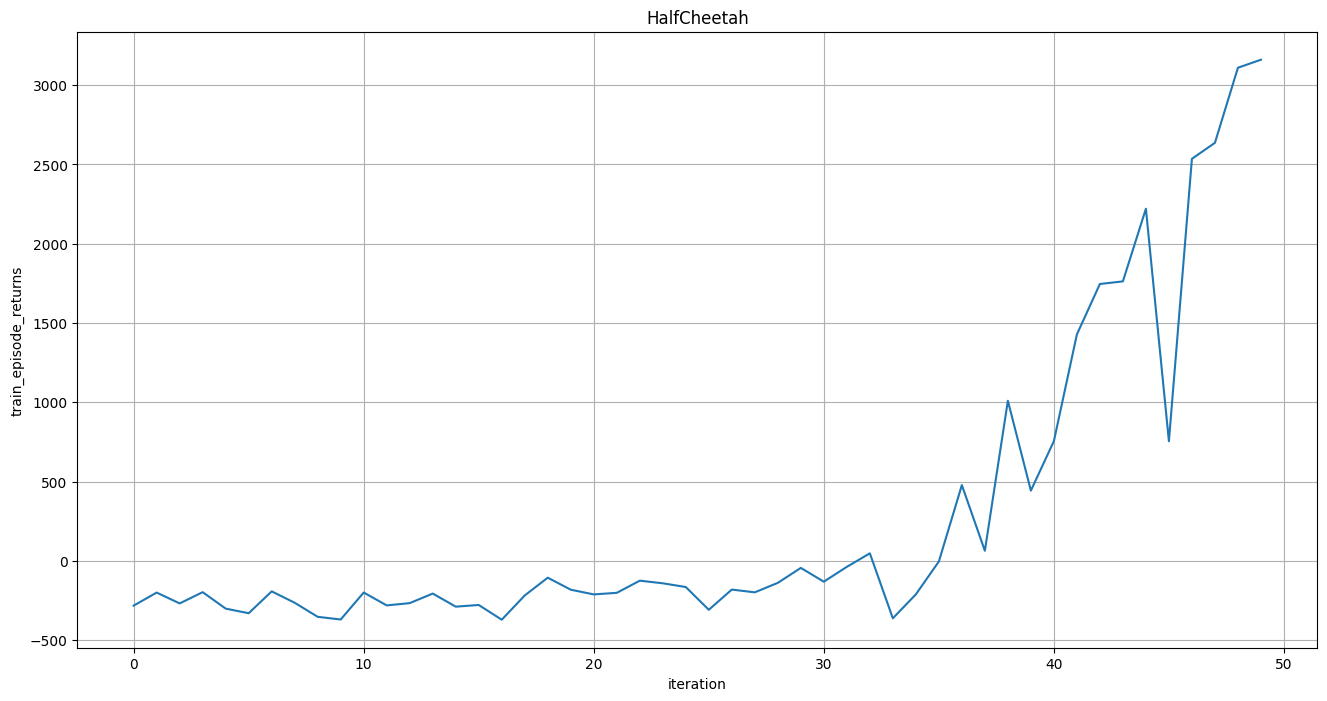

In [14]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(
    x='iteration', y='train_episode_returns',
    data=sac_data, ax=ax)
plt.title(GAME)
plt.grid()
plt.show()